In [4]:
import torch 
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataloader import DataLoader
from meta_learning.datasets import OmniglotDataset
from meta_learning.utils import acc_classification
from meta_learning.models import SimpleCNN
from meta_learning.meta_grads import maml_grad
import random


nways = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#%%
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
bsize = 8
ksize = 5
dataset = OmniglotDataset(k=ksize+1, n=nways, ntrain=800, is_train=True)
dataset_test = OmniglotDataset(k=ksize, n=nways, ntrain=800, is_train=False)

loader = torch.utils.data.DataLoader(dataset, batch_size=bsize, num_workers=3)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, num_workers=3)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model = SimpleCNN(nways).to(device)
opt_outer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [8]:
eps=1000
ii = 0
writer = SummaryWriter('tb/maml_grad_'+str(random.random()))
for ep in range(eps):
    for step, (x, y) in enumerate(loader):
        xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
        yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)
        opt_outer.zero_grad()
        loss, accuraccy = maml_grad(model, xexamples, yexamples, xtoguess, ytoguess, 0.05)
        opt_outer.step()
        writer.add_scalar('metric/loss', loss, ii := ii+1)
        writer.add_scalar('metric/accu', accuraccy, ii)
        import time 
        time.sleep(5) 
        print(ep, step, loss, accuraccy)

0 0 0.3469550795853138 0.25
0 1 0.34771376848220825 0.25
0 2 0.3465868718922138 0.25
0 3 0.34698327258229256 0.25
0 4 0.34701237827539444 0.25
0 5 0.3469054847955704 0.28125
0 6 0.34673256427049637 0.25
0 7 0.34654466062784195 0.25
0 8 0.3464195393025875 0.34375
0 9 0.34674423187971115 0.21875
0 10 0.34592830017209053 0.34375
0 11 0.34633610770106316 0.28125
0 12 0.34605030342936516 0.3125
0 13 0.3474644087255001 0.21875
0 14 0.34649283438920975 0.28125
0 15 0.3464432433247566 0.28125
0 16 0.3468070700764656 0.21875
0 17 0.34658515453338623 0.28125
0 18 0.3468625769019127 0.25
0 19 0.3472384437918663 0.25
0 20 0.3467986658215523 0.3125
0 21 0.3467698395252228 0.21875
0 22 0.3472948633134365 0.21875
0 23 0.3460821099579334 0.25
0 24 0.34644385799765587 0.28125
0 25 0.3464783765375614 0.28125
0 26 0.3461587652564049 0.1875
0 27 0.3469066321849823 0.21875
0 28 0.34656473621726036 0.1875
0 29 0.3475944213569164 0.15625
0 30 0.3468848541378975 0.25
0 31 0.3473951295018196 0.21875
0 32 0.346

# Testing

In [16]:
for x, y in loader_test:
    break
xexamples, xtoguess = x[:, :-1], x[:, -1].unsqueeze(1)
yexamples, ytoguess = y[:, :-1], y[:, -1].unsqueeze(1)

## Untrained net on 3 grad steps
### accuracy = 0.273

In [24]:
reptile_optimize(SimpleCNN(nways), xexamples, yexamples, xtoguess, ytoguess, 1e-2, 5, 0.9, update_model=False)

(0.34665910596959293,
 0.33203125,
 tensor([[[0.2634, 0.2669, 0.2455, 0.2242],
          [0.2630, 0.2673, 0.2455, 0.2242],
          [0.2638, 0.2665, 0.2454, 0.2243],
          [0.2631, 0.2672, 0.2454, 0.2243]]], grad_fn=<ViewBackward>))

## Trained net on 5 grad steps
### accuracy = 0.633

In [23]:
reptile_optimize(model, xexamples, yexamples, xtoguess, ytoguess, 1e-2, 5, 0.9, update_model=False)

(0.3388259964995086,
 0.439453125,
 tensor([[[0.0235, 0.2753, 0.1898, 0.5114],
          [0.0102, 0.2851, 0.1641, 0.5406],
          [0.0086, 0.2796, 0.1751, 0.5366],
          [0.0035, 0.2529, 0.1336, 0.6100]]], grad_fn=<ViewBackward>))

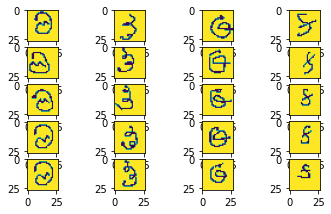

In [66]:
br = 0
for i, kx in enumerate(torch.cat((xexamples[0], xtoguess[0]), dim=0)):
    for j, x in enumerate(kx):
        plt.subplot(ksize+1, nways, br := br+1)
        plt.imshow(x.numpy())